# Project 2 - Wholesale Customer

**Context:** The data set refers to clients of a wholesale distributor. It includes the annual spending in 
monetary units on diverse product categories.

**Dataset Source:** Excel File attached

**Task:**  Goal of this project is to best describe the variation in the different types of customers that a 
wholesale distributor interacts with.

## Table of Contents

1. [Perform EDA & data cleaning if necessary](#EDA)
2. [Implement feature scaling to normalize the data](#feature-scaling)
3. [Find optimal number of features using RFECV](#optimal-features)
4. [Implement K-means Clustering](#kmeans)
5. [Implement Prinicpal Component Analysis(PCA)](#pca)
6. [Implement XGBoost classifier](#xgboost)

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import Image
from IPython.core.display import HTML 
from pylab import rcParams
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
customers = pd.read_csv('Wholesale customers data.csv')
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 1. Perform EDA & data cleaning if necessary. <a name="EDA"></a>

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Data cleaning is not necessary because :-
1. No null/missing values.
2. No irrelevant/repetitive variables.

**EDA :- 3 types of Plots**

_1. Categorical Plots_

<Figure size 432x288 with 0 Axes>

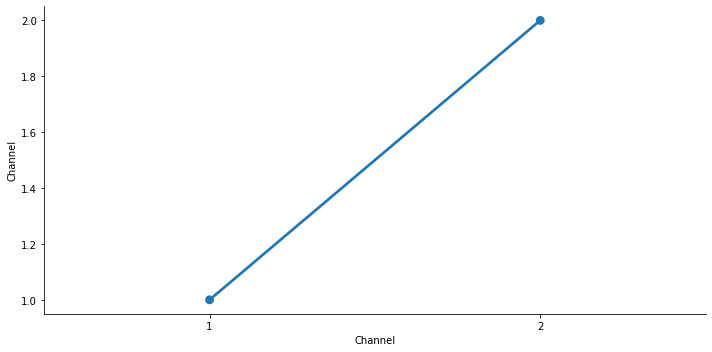

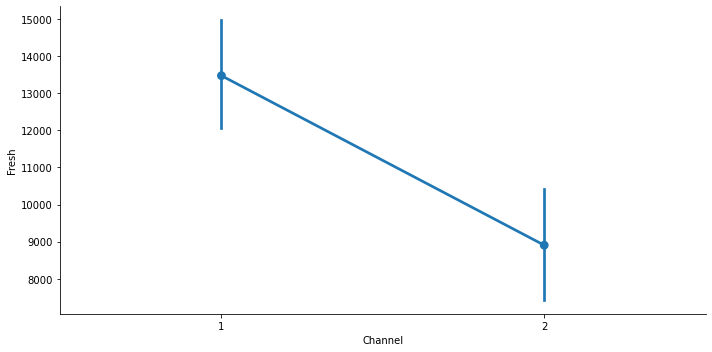

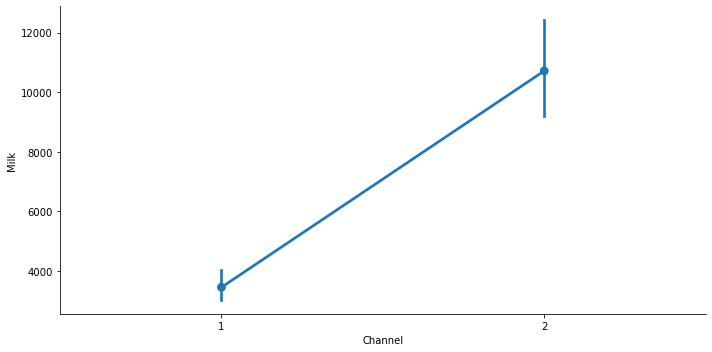

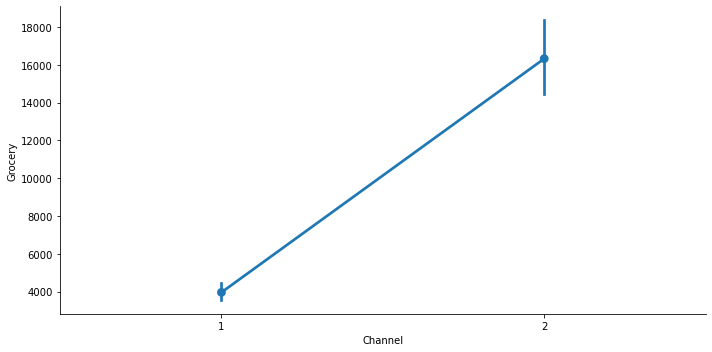

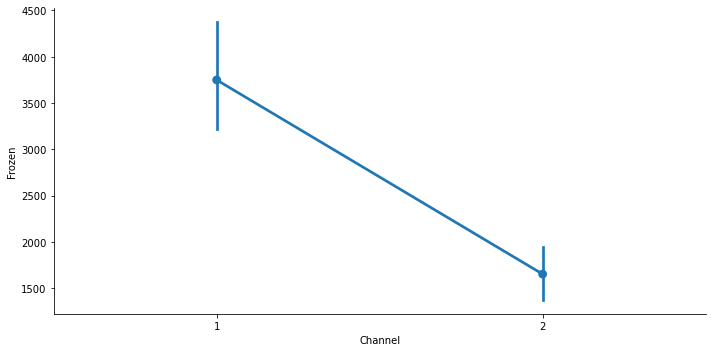

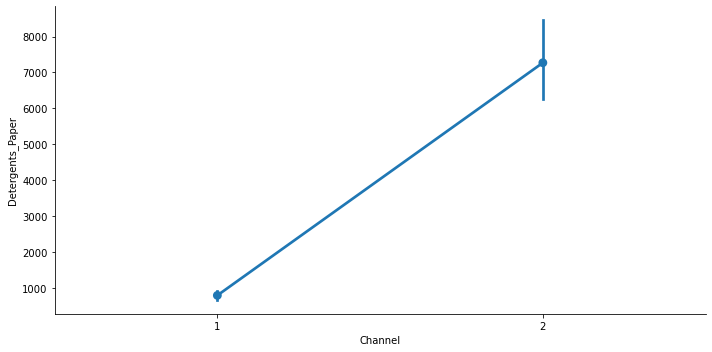

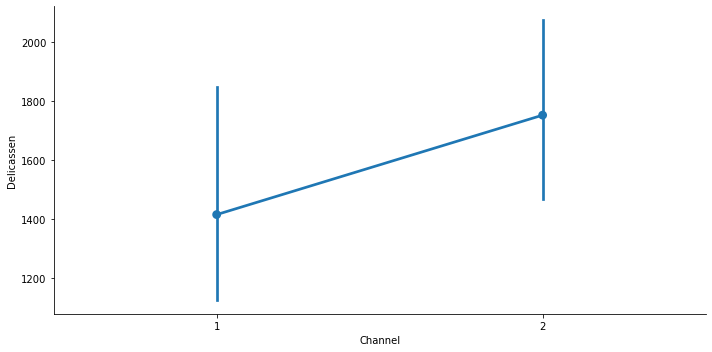

In [5]:
## Plotting the features in 3 different types of plots

for i, col in enumerate(['Channel', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']):
    plt.figure(i)
    sb.catplot(x='Channel', y=col, data=customers, kind='point', aspect=2,)

    

_2. Scatter Plot_

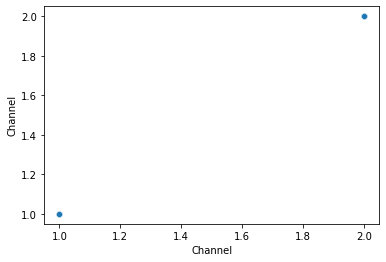

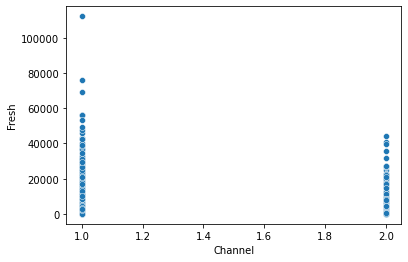

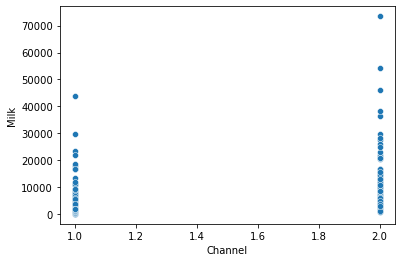

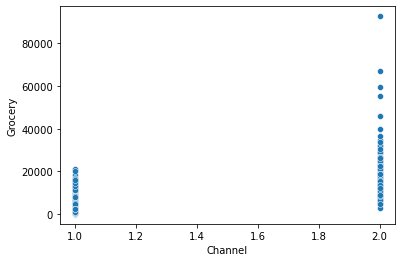

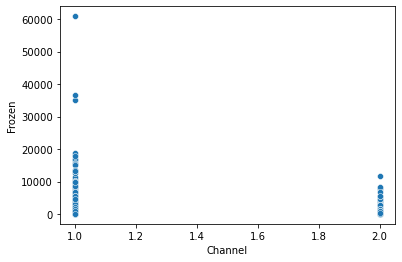

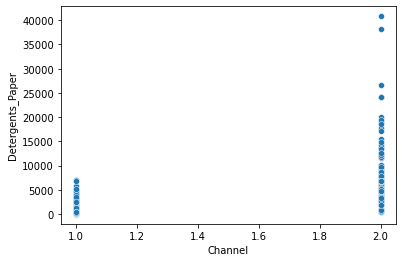

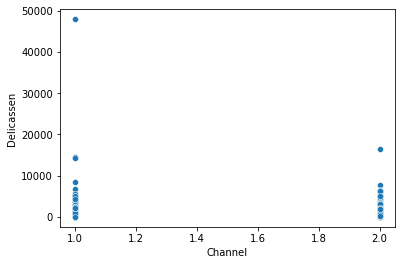

In [6]:
for i, col in enumerate(['Channel', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']):
    plt.figure(i)
    sb.scatterplot(x='Channel', y=col, data=customers,)

_3. Overlaid Histogram_

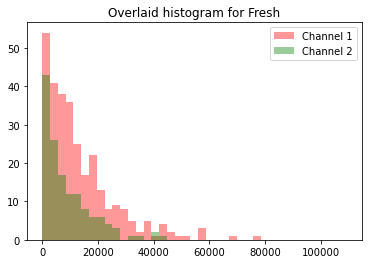

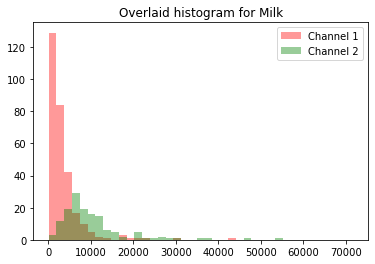

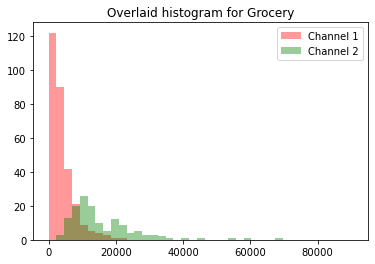

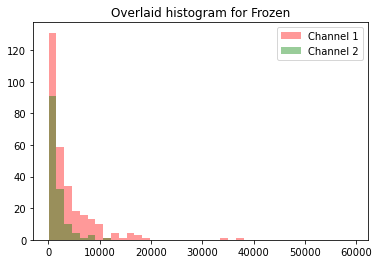

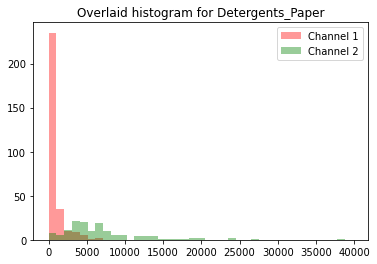

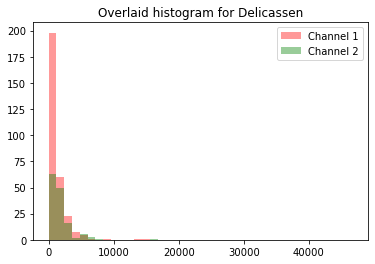

In [7]:
import seaborn as sb
for i in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    died = list(customers[customers['Channel'] == 1][i].dropna())
    survived = list(customers[customers['Channel'] == 2][i].dropna())
    xmin = min(min(died), min(survived))
    xmax = max(max(died), max(survived))
    width = (xmax - xmin) / 40
    sb.distplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sb.distplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Channel 1', 'Channel 2'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

## 2. Implement feature scaling to normalize the data <a name="feature-scaling"></a>

### Types of Scalers :-

### A. StandardScaler

The most commonly used scaler—as the name indicates—is `StandardScaler`. 

This standardizes features by removing the mean and scaling to unit variance.  It loosely assumes that the underlying data is Gaussian to start with, but mostly it is fairly robust against moderate violations of that distribution.  Calculating the mean and standard deviation is per-column (as for all scalers).

In [8]:
from sklearn.preprocessing import StandardScaler
scaled1 = StandardScaler().fit_transform(customers)
scaled1[:5]

array([[ 1.44865163,  0.59066829,  0.05293319,  0.52356777, -0.04111489,
        -0.58936716, -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197,  0.54445767,  0.17031835,
        -0.27013618,  0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926,  0.40853771, -0.0281571 ,
        -0.13753572,  0.13323164,  2.24329255],
       [-0.69029709,  0.59066829,  0.10011141, -0.62401993, -0.3929769 ,
         0.6871443 , -0.49858822,  0.09341105],
       [ 1.44865163,  0.59066829,  0.84023948, -0.05239645, -0.07935618,
         0.17385884, -0.23191782,  1.29934689]])

In [9]:
pd.DataFrame(scaled1).describe().head(3)

,0,1,2,3,4,5,6,7
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-2.452584e-16,-5.737834e-16,-2.422305e-17,-1.589638e-17,-6.030530e-17,1.135455e-17,-1.917658e-17,-8.276208e-17
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00


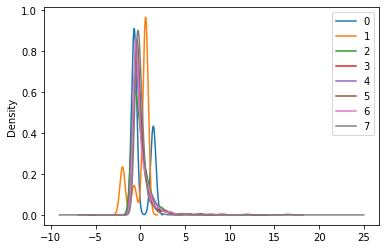

In [10]:
pd.DataFrame(scaled1).plot(kind='kde');

_Kernel Density varies only for feature range (-0.5, 0.5). Highest Kernel density at 1._

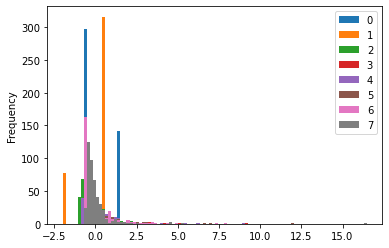

In [11]:
pd.DataFrame(scaled1).plot(kind='hist', bins=100);

_Frequency varies from 0 to 300 only for feature range (-0.22, 1.75). The frequency for the rest of the features stays minimal. Highest frequency at around 1.0._

### B. MinMaxScaler

Transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, by default between zero and one.

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaled2 = MinMaxScaler().fit_transform(customers)
scaled2[:5]

array([[1.        , 1.        , 0.11294004, 0.13072723, 0.08146416,
        0.0031063 , 0.0654272 , 0.02784731],
       [1.        , 1.        , 0.06289903, 0.13282409, 0.10309667,
        0.02854842, 0.08058985, 0.03698373],
       [1.        , 1.        , 0.05662161, 0.11918086, 0.08278992,
        0.03911643, 0.08605232, 0.16355861],
       [0.        , 1.        , 0.11825445, 0.01553586, 0.04546385,
        0.10484189, 0.01234568, 0.03723404],
       [1.        , 1.        , 0.20162642, 0.07291369, 0.07755155,
        0.063934  , 0.04345483, 0.10809345]])

In [13]:
pd.DataFrame(scaled2).describe()

,0,1,2,3,4,5,6,7
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.322727,0.771591,0.106977,0.078173,0.085671,0.050078,0.070510,0.031745
std,0.468052,0.387136,0.112774,0.100491,0.102430,0.079789,0.116790,0.058826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.027863,0.020124,0.023174,0.011788,0.006216,0.008453
50%,0.000000,1.000000,0.075802,0.048636,0.051225,0.024670,0.019927,0.020077
75%,1.000000,1.000000,0.150968,0.097154,0.114821,0.058005,0.095997,0.037907
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


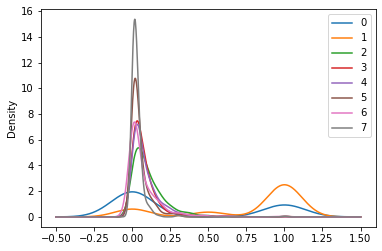

In [14]:
pd.DataFrame(scaled2).plot(kind='kde');

_Kernel Density varies all the way from -0.5 to to 1.50. Highest kernel density is at 0._

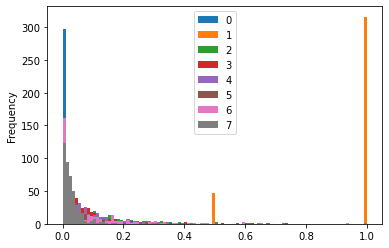

In [15]:
pd.DataFrame(scaled2).plot(kind='hist', bins=100);

_Frequency varies from 0 to 300 only for feature range (0, 0.1), 50 at 0.5 and highest frequency at 1.0. The frequency for the rest of the features stays minimal._

In the two scaling methods applied above, we can notice that the KDE plot for MinMaxScaler shows variable density from -0.5 features until 1.5 features whereas the KDE plot for StandardScaler shows variable density only from feature range (-0.5, 0.5), making it a better scaling solution. Hence, this shows that the Standard Scaler method would give us more optimal number of features and more optimal solution than the MinMaxScaler.

## 3. Find optimal number of features using RFECV <a name="optimal-features"></a>

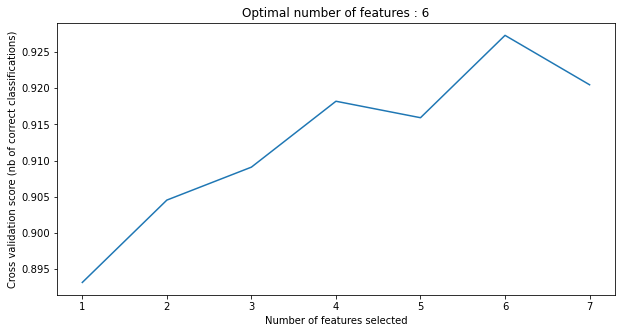

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

rf = RandomForestClassifier(max_depth=7, random_state=1)
rfecv = RFECV(estimator=rf)
features = customers.drop("Channel", axis=1)
rfecv.fit(features, customers['Channel'])

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()

Thus, we can see that the optimal number of features is **6**

## 4. Implement K-means Clustering <a name="kmeans"></a>

In [17]:
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
K = range(2,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(scaled2)
    sum_of_squared_distances.append(k_means.inertia_)
    

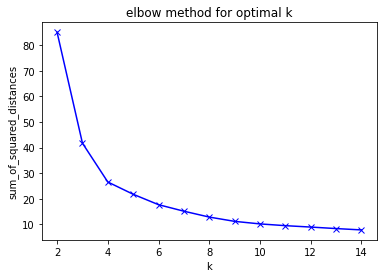

In [18]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

Here we can see the drop in the sum of squared distance starts to slow down after **k = 4**. Hence **4** is the optimal number of clusters for our analysis.

## 5. Implement Principal Component Analysis(PCA) <a name="pca"></a>

In [19]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca_customers = pd.read_csv('Wholesale customers data.csv')
X = pca_customers
variable_names = pca_customers.columns
X[0:10]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [20]:
pca_customers.keys()

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

**Variance explained by first 2 components**

In [21]:
pca = decomposition.PCA(n_components=2)
customers_pca1 = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.45961362, 0.40517227])

In [22]:
pca.explained_variance_ratio_.sum()

0.8647858832196771

In [23]:
comps1 = pd.DataFrame(pca.components_, columns=variable_names)
comps1

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,-0.000004,3.328850e-06,0.976537,0.121184,0.061540,0.152365,-0.007054,0.068105
1,0.000024,5.754103e-07,-0.110614,0.515802,0.764606,-0.018723,0.365351,0.057079


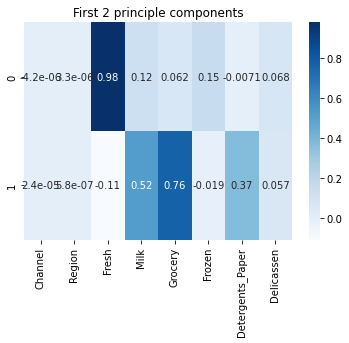

In [24]:
ax = plt.axes()
sb.heatmap(comps1, cmap="Blues", annot=True, ax = ax)
ax.set_title('First 2 principle components')
plt.show()

**Variance explained by first 4 components**

In [25]:
pca = decomposition.PCA(n_components=4)
customers_pca2 = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.45961362, 0.40517227, 0.07003008, 0.04402344])

In [26]:
pca.explained_variance_ratio_.sum()

0.9788394069877697

In [27]:
comps2 = pd.DataFrame(pca.components_, columns=variable_names)
comps2

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,-0.000004,3.328850e-06,0.976537,0.121184,0.061540,0.152365,-0.007054,0.068105
1,0.000024,5.754103e-07,-0.110614,0.515802,0.764606,-0.018723,0.365351,0.057079
2,-0.000014,-1.814881e-06,-0.178557,0.509887,-0.275781,0.714200,-0.204410,0.283217
3,0.000003,1.104086e-05,0.041876,0.645640,-0.375460,-0.646292,-0.149380,0.020396


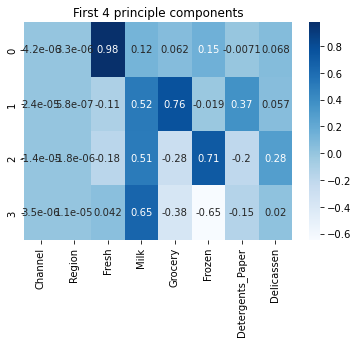

In [28]:
ax = plt.axes()
sb.heatmap(comps2, cmap="Blues", annot=True)
ax.set_title('First 4 principle components')
plt.show()

## 6. Implement XGBoost classifier <a name="xgboost"></a>

Install module

In [29]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [30]:
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# train-test split evaluation of xgboost model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#splitting the data
features= customers['Channel']
customers.drop('Channel', axis=1, inplace=True)
X= customers
Y= features
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

#Implementing xgoost with 5 fold CV
xgB = xgboost.XGBClassifier(eval_metric ='logloss')
kfold = KFold(n_splits=5)

**Reporting the performance metrics :-**

In [31]:
print ("Accuracy score: {}".format(cross_val_score(xgB, X_train, y_train, cv=kfold, scoring='accuracy')))

Accuracy score: [0.91525424 0.84745763 0.84745763 0.88135593 0.9137931 ]


In [32]:
print ("Precision score: {}".format(cross_val_score(xgB, X_train, y_train, cv=kfold, scoring='precision')))

Precision score: [0.95348837 0.83333333 0.87179487 0.97435897 0.97058824]


In [33]:
print ("Recall score: {}".format(cross_val_score(xgB, X_train, y_train, cv=kfold, scoring='recall')))

Recall score: [0.93181818 0.94594595 0.89473684 0.86363636 0.89189189]
